# Import data from Repo add additional data and Merge to one Dataset

In [1]:
import pandas as pd
import holidays

# Define the URLs for the additional datasets
kiwo_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv'
wetter_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv'
umsatzdaten_gekuerzt_url = 'https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv'

# Load the datasets
kiwo = pd.read_csv(kiwo_url, delimiter=',')
wetter = pd.read_csv(wetter_url, delimiter=',')
umsatzdaten_gekuerzt = pd.read_csv(umsatzdaten_gekuerzt_url, delimiter=',')

# Merge datasets with a left join to retain all rows from wetter
wetter_umsatzdaten = pd.merge(wetter, umsatzdaten_gekuerzt, on="Datum", how="left")

# Add KiWo flag
wetter_umsatzdaten['KiWo'] = wetter_umsatzdaten['Datum'].isin(kiwo['Datum']).astype(int)

# Convert the 'Datum' column to datetime
wetter_umsatzdaten['Datum'] = pd.to_datetime(wetter_umsatzdaten['Datum'])

# Define the range of years
years = range(2012, 2019 + 1)

# Create a list to store the holidays
holidays_sh = []

# Loop through each year and get the holidays for Schleswig-Holstein
for year in years:
    for date, name in holidays.Germany(years=year, state='SH').items():
        holidays_sh.append((date, name))

# Create a set of holiday dates
holiday_dates = set(date for date, name in holidays_sh)

# Add a new column 'Holiday' to the wetter_umsatzdaten dataframe
wetter_umsatzdaten['Holiday'] = wetter_umsatzdaten['Datum'].apply(lambda x: 1 if pd.to_datetime(x).date() in holiday_dates else 0)

# Replace NaN in Umsatz with 0\n",
wetter_umsatzdaten['Umsatz'] = wetter_umsatzdaten['Umsatz'].fillna(0)
    # Replace NaN in Warengruppe with 0
wetter_umsatzdaten['Warengruppe'] = wetter_umsatzdaten['Warengruppe'].fillna(0).astype(int)


# Create a new column 'ID' to match the sample submission format (YYMMDDW)
wetter_umsatzdaten['ID'] = (
    wetter_umsatzdaten['Datum'].dt.strftime('%y%m%d').astype(str) + 
    wetter_umsatzdaten['Warengruppe'].astype(str)
).astype(int)

# Print the first few rows to verify the new ID format
print(wetter_umsatzdaten[['Datum', 'Warengruppe', 'ID']].head())

# Save merged dataset directly
wetter_umsatzdaten.to_csv("wetter_umsatzdaten_kiwo_hol_id.csv", index=False)

print("Merge complete. Data saved for subsequent processing.")

#Load the merged dataset
wetter_umsatzdaten_kiwo = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id.csv")


       Datum  Warengruppe       ID
0 2012-01-01            0  1201010
1 2012-01-02            0  1201020
2 2012-01-03            0  1201030
3 2012-01-04            0  1201040
4 2012-01-05            0  1201050
Merge complete. Data saved for subsequent processing.


# Inspect data for missing values

In [2]:
import missingno as msno
from matplotlib import pyplot as plt

print("Data Overview:")
print(wetter_umsatzdaten_kiwo.info())
print("Shape of Data:", wetter_umsatzdaten_kiwo.shape)
print("Missing values per column:")
print(df.isnull().sum())
#print(wetter_umsatzdaten.head())
#print(wetter_umsatzdaten.tail())

#Load the data
df = wetter_umsatzdaten_kiwo.copy()
print(df.info())

#barplot of complete data
msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()

#Visualize missing data for 'Bewoelkung'
msno.matrix(df, figsize=(12, 6))
plt.title('Missing Data Matrix Plot')
plt.show()


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10103 entries, 0 to 10102
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Datum                10103 non-null  object 
 1   Bewoelkung           10048 non-null  float64
 2   Temperatur           10103 non-null  float64
 3   Windgeschwindigkeit  10103 non-null  int64  
 4   Wettercode           7581 non-null   float64
 5   id                   9318 non-null   float64
 6   Warengruppe          10103 non-null  int64  
 7   Umsatz               10103 non-null  float64
 8   KiWo                 10103 non-null  int64  
 9   Holiday              10103 non-null  int64  
 10  ID                   10103 non-null  int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 868.4+ KB
None
Shape of Data: (10103, 11)
Missing values per column:


NameError: name 'df' is not defined

# Imputation of Bewoelkung

8347   2017-10-30
8348   2017-10-30
8349   2017-10-30
8350   2017-10-30
8351   2017-10-30
8352   2017-10-30
8353   2017-10-31
8354   2017-11-01
8355   2017-11-01
8356   2017-11-01
8357   2017-11-01
8358   2017-11-01
8359   2017-11-01
8360   2017-11-02
8361   2017-11-02
8362   2017-11-02
8363   2017-11-02
8364   2017-11-02
8365   2017-11-02
8366   2017-11-03
8367   2017-11-03
8368   2017-11-03
8369   2017-11-03
8370   2017-11-03
8371   2017-11-03
8372   2017-11-04
8373   2017-11-04
8374   2017-11-04
8375   2017-11-04
8376   2017-11-04
8377   2017-11-04
8378   2017-11-05
8379   2017-11-05
8380   2017-11-05
8381   2017-11-05
8382   2017-11-05
8383   2017-11-05
8384   2017-11-06
8385   2017-11-06
8386   2017-11-06
8387   2017-11-06
8388   2017-11-06
8389   2017-11-06
8390   2017-11-07
8391   2017-11-07
8392   2017-11-07
8393   2017-11-07
8394   2017-11-07
8395   2017-11-07
8396   2017-11-08
8397   2017-11-08
8398   2017-11-08
8399   2017-11-08
8400   2017-11-08
8401   2017-11-08
Name: Datu

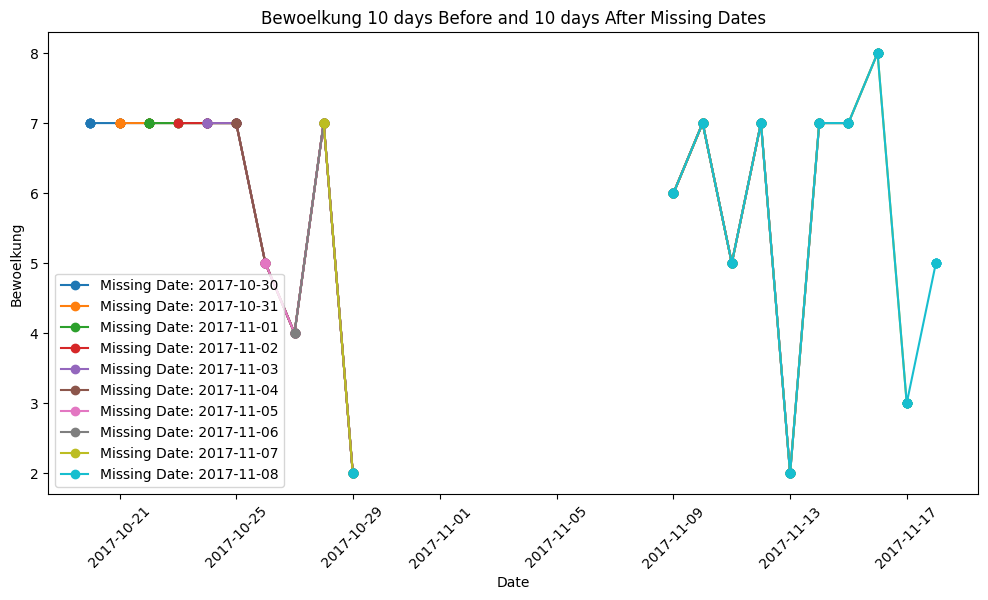

       Datum  Bewoelkung
0 2012-01-01         8.0
1 2012-01-02         7.0
2 2012-01-03         8.0
3 2012-01-04         4.0
4 2012-01-05         6.0
5 2012-01-06         3.0
6 2012-01-07         7.0
7 2012-01-08         7.0
8 2012-01-09         8.0
9 2012-01-10         6.0
Statistics of the un-imputed column (Bewoelkung):
count    10103.000000
mean         4.746511
std          2.627207
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max          8.000000
Name: Bewoelkung, dtype: float64

Statistics of the imputed column (Bewoelkung):
count    10103.000000
mean         4.746511
std          2.627207
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max          8.000000
dtype: float64


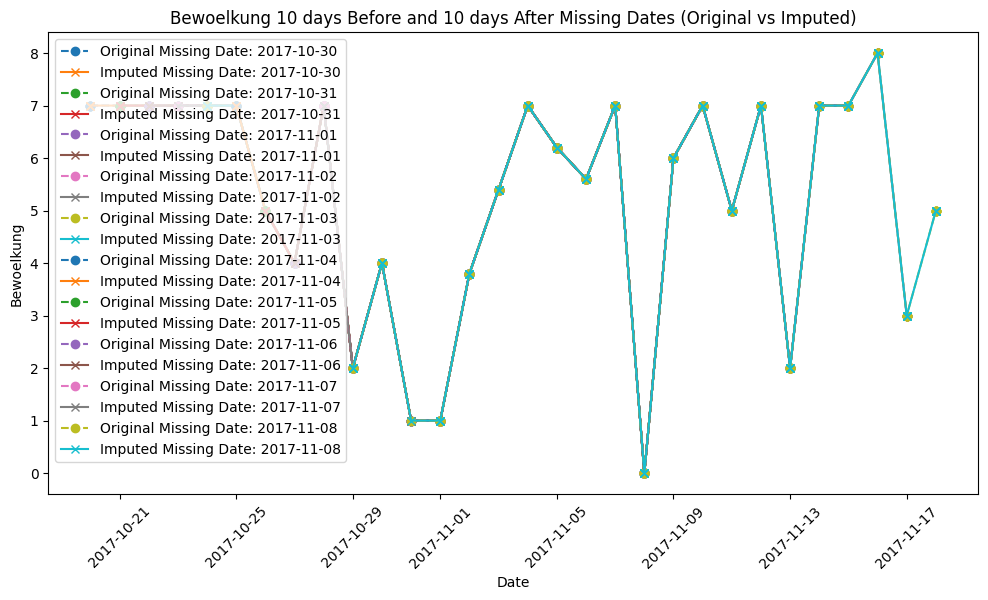

       Datum  Bewoelkung  Bewoelkung_Imputed
0 2012-01-01         8.0                   0
1 2012-01-02         7.0                   0
2 2012-01-03         8.0                   0
3 2012-01-04         4.0                   0
4 2012-01-05         6.0                   0
5 2012-01-06         3.0                   0
6 2012-01-07         7.0                   0
7 2012-01-08         7.0                   0
8 2012-01-09         8.0                   0
9 2012-01-10         6.0                   0


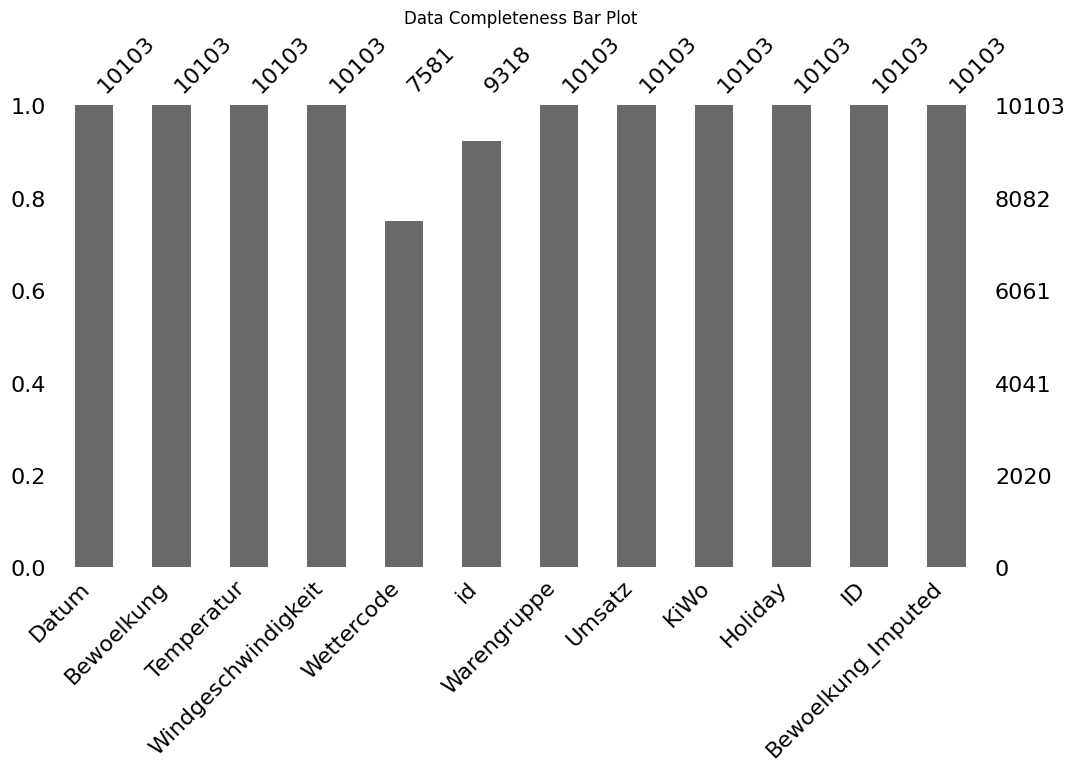

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

# Ensure that 'Datum' is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

# Extract dates with missing 'Bewoelkung' values
missing_bewoelkung_dates = df[df['Bewoelkung'].isnull()]['Datum']
print(missing_bewoelkung_dates)

# Convert to datetime, though it should already be in the correct format
missing_bewoelkung_dates = pd.to_datetime(missing_bewoelkung_dates)

# Extract the unique missing dates
unique_missing_dates = missing_bewoelkung_dates.unique()

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each missing date
for missing_date in unique_missing_dates:
    # Ensure missing_date is a datetime object
    missing_date = pd.to_datetime(missing_date)
    
    # Define the date range (one week before and one week after)
    start_date = missing_date - pd.Timedelta(days=10)
    end_date = missing_date + pd.Timedelta(days=10)
    
    # Filter the dataframe for the date range
    date_range_df = df[(df['Datum'] >= start_date) & (df['Datum'] <= end_date)]
    
    # Plot the Bewoelkung variable
    ax.plot(date_range_df['Datum'], date_range_df['Bewoelkung'], marker='o', label=f'Missing Date: {missing_date.date()}')

# Set the title and labels
ax.set_title('Bewoelkung 10 days Before and 10 days After Missing Dates')
ax.set_xlabel('Date')
ax.set_ylabel('Bewoelkung')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Select the columns to be used for KNN imputation
columns_for_imputation = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit']

# Create a copy of the dataframe with only the relevant columns
df_impute = df[columns_for_imputation].copy()

# Initialize the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df_imputed = knn_imputer.fit_transform(df_impute)

# Update the original dataframe with the imputed values
df['Bewoelkung'] = df_imputed[:, 0]

# Verify the imputation
print(df[['Datum', 'Bewoelkung']].head(10))

# Statistics of the un-imputed column
unimputed_stats = df['Bewoelkung'].describe()

# Statistics of the imputed column
imputed_stats = pd.Series(df_imputed[:, 0]).describe()

# Print the statistics
print("Statistics of the un-imputed column (Bewoelkung):")
print(unimputed_stats)
print("\nStatistics of the imputed column (Bewoelkung):")
print(imputed_stats)

# Create a figure and axis for comparing original vs imputed data
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through each missing date
for missing_date in unique_missing_dates:
    # Define the date range (one week before and one week after)
    start_date = missing_date - pd.Timedelta(days=10)
    end_date = missing_date + pd.Timedelta(days=10)
    
    # Filter the dataframe for the date range
    date_range_df = df[(df['Datum'] >= start_date) & (df['Datum'] <= end_date)]
    date_range_df_imputed = df[(df['Datum'] >= start_date) & (df['Datum'] <= end_date)]
    
    # Plot the Bewoelkung variable without imputation (before)
    ax.plot(date_range_df['Datum'], date_range_df['Bewoelkung'], marker='o', linestyle='--', label=f'Original Missing Date: {missing_date.date()}')
    
    # Plot the Bewoelkung variable with imputation (after)
    ax.plot(date_range_df_imputed['Datum'], date_range_df_imputed['Bewoelkung'], marker='x', linestyle='-', label=f'Imputed Missing Date: {missing_date.date()}')

# Set the title and labels for comparison plot
ax.set_title('Bewoelkung 10 days Before and 10 days After Missing Dates (Original vs Imputed)')
ax.set_xlabel('Date')
ax.set_ylabel('Bewoelkung')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
ax.legend()

# Show the plot
plt.show()

# Create a mask for the original missing values
missing_mask_bewoelkung = df['Bewoelkung'].isnull()

# Add a column to mark the imputed values
df['Bewoelkung_Imputed'] = missing_mask_bewoelkung.astype(int)

# Verify the new column
print(df[['Datum', 'Bewoelkung', 'Bewoelkung_Imputed']].head(10))

#barplot of complete data
msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()


# Imputation for Wettercode

       Datum  Wettercode
0 2012-01-01        58.0
1 2012-01-02        53.0
2 2012-01-03        63.0
3 2012-01-04        80.0
4 2012-01-05        80.0
5 2012-01-06        61.0
6 2012-01-07        61.0
7 2012-01-08        80.0
8 2012-01-09        61.0
9 2012-01-10        61.0
Statistics of the imputed column (Wettercode):
count    10103.000000
mean        33.225458
std         27.488488
min          0.000000
25%          5.000000
50%         21.000000
75%         61.000000
max         95.000000
dtype: float64
Statistics of the un-imputed column (Wettercode):
count    10103.000000
mean        33.225458
std         27.488488
min          0.000000
25%          5.000000
50%         21.000000
75%         61.000000
max         95.000000
Name: Wettercode, dtype: float64


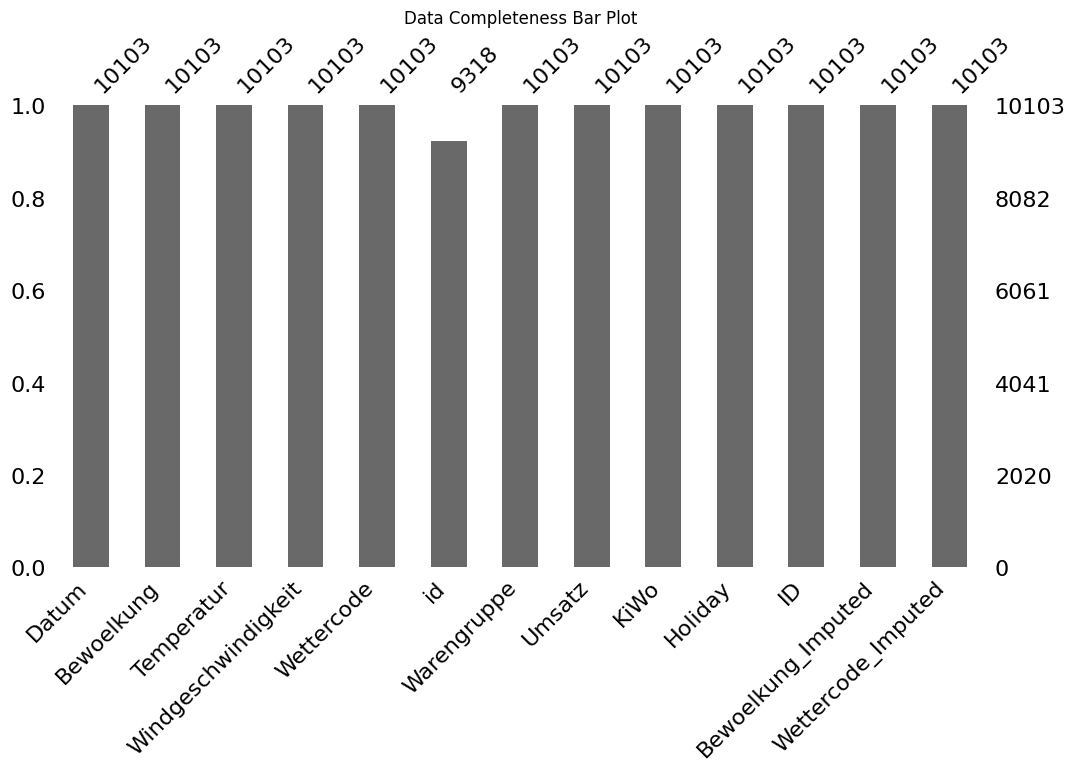

In [15]:
from sklearn.impute import KNNImputer

# Select the columns to be used for KNN imputation
columns_for_imputation = ['Bewoelkung', 'Temperatur', 'Windgeschwindigkeit', 'Wettercode']

# Create a copy of the dataframe with only the relevant columns
df_impute = df[columns_for_imputation].copy()

# Initialize the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform the imputation
df_imputed = knn_imputer.fit_transform(df_impute)

# Update the original dataframe with the imputed values
df['Wettercode'] = df_imputed[:, 3]

# Verify the imputation
print(df[['Datum', 'Wettercode']].head(10))

# Statistics of the imputed column
imputed_stats_wettercode = pd.Series(df_imputed[:, 3]).describe()

# Create a mask for the original missing values
missing_mask_wettercode = df['Bewoelkung'].isnull()
#Add a column to mark the imputed values
df['Wettercode_Imputed'] = missing_mask_wettercode.astype(int)


# Print the statistics
print("Statistics of the imputed column (Wettercode):")
print(imputed_stats_wettercode)

# Statistics of the un-imputed column
unimputed_stats_wettercode = df['Wettercode'].describe()

# Print the statistics
print("Statistics of the un-imputed column (Wettercode):")
print(unimputed_stats_wettercode)


#barplot of complete data
msno.bar(df, figsize=(12, 6))
plt.title('Data Completeness Bar Plot')
plt.show()

#save the data
df.to_csv("wetter_umsatzdaten_kiwo_hol_id_imputed.csv", index=False)


# Feature Engineering

In [18]:
#load the unimputed data
wetter_umsatzdaten_kiwo = pd.read_csv("../0_DataPreparation/wetter_umsatzdaten_kiwo_hol_id.csv")

# Load the imputed data
#wetter_umsatzdaten_kiwo = pd.read_csv("wetter_umsatzdaten_kiwo_hol_id_imputed.csv")

# Convert 'Datum' to datetime and add a weekday column
wetter_umsatzdaten_kiwo['Datum'] = pd.to_datetime(wetter_umsatzdaten_kiwo['Datum'], errors='coerce')
wetter_umsatzdaten_kiwo['Wochentag'] = wetter_umsatzdaten_kiwo['Datum'].dt.day_name()
wetter_umsatzdaten_kiwo['Is_Weekend'] = wetter_umsatzdaten_kiwo['Datum'].dt.weekday.isin([5, 6]).astype(int)

# Add a temperature category
def classify_temperature(temp):
    if temp < 0:
        return -2  # Very Cold
    elif 0 <= temp <= 10:
        return -1  # Cold
    elif 10 < temp <= 20:
        return 1   # Warm
    else:
        return 2   # Very Warm

wetter_umsatzdaten_kiwo['Temperature_Category'] = wetter_umsatzdaten_kiwo['Temperatur'].apply(classify_temperature)


# Add a Beaufort scale categorization function
def classify_wind_speed_beaufort(wind_speed):
    if wind_speed <= 0.2:
        return 0  # Calm
    elif wind_speed <= 1.5:
        return 1  # Light Air
    elif wind_speed <= 3.3:
        return 2  # Light Breeze
    elif wind_speed <= 5.4:
        return 3  # Gentle Breeze
    elif wind_speed <= 7.9:
        return 4  # Moderate Breeze
    elif wind_speed <= 10.7:
        return 5  # Fresh Breeze
    elif wind_speed <= 13.8:
        return 6  # Strong Breeze
    elif wind_speed <= 17.1:
        return 7  # Near Gale
    elif wind_speed <= 20.7:
        return 8  # Gale
    elif wind_speed <= 24.4:
        return 9  # Strong Gale
    elif wind_speed <= 28.4:
        return 10  # Storm
    elif wind_speed <= 32.6:
        return 11  # Violent Storm
    else:
        return 12  # Hurricane

wetter_umsatzdaten_kiwo['Windgeschwindigkeit_Beaufort'] = wetter_umsatzdaten_kiwo['Windgeschwindigkeit'].apply(classify_wind_speed_beaufort)

# Add a column for Rain_Status based on Wettercode
def map_rain_status(wettercode):
    rain_status_mapping = {
        0: 0,
        20: 0,
        21: 0,
        61: 1,
        63: 1,
        65: 1,
        95: 2
    }
    return rain_status_mapping.get(wettercode, -1)  # Default to -1 for unknown codes

wetter_umsatzdaten_kiwo['Rain_Status'] = wetter_umsatzdaten_kiwo['Wettercode'].apply(map_rain_status)

#Add acolumn for Cloud_Status based on Bewölkung
def map_cloud_status(bewoelkung):
    if bewoelkung < 1:
        return 0  # sunny
    elif bewoelkung <= 3:
        return 1 # clear
    elif bewoelkung <= 6:
        return 2  # Partly Cloudy
    elif bewoelkung <= 7:
        return 3  # Cloudy
    else:
        return 4  # totally Cloudy

wetter_umsatzdaten_kiwo['Cloud_Status'] = wetter_umsatzdaten_kiwo['Bewoelkung'].apply(map_cloud_status)


# Generate rows for all Warengruppe categories where Warengruppe is 0
unique_warengruppen = wetter_umsatzdaten_kiwo['Warengruppe'].unique()
rows_with_zero_warengruppe = wetter_umsatzdaten_kiwo[wetter_umsatzdaten_kiwo['Warengruppe'] == 0]

#Expand rows for each Warengruppe
expanded_rows = []
for _, row in rows_with_zero_warengruppe.iterrows():
    for warengruppe in unique_warengruppen:
        if warengruppe != 0:  # Exclude 0 as it's already in the dataset
            new_row = row.copy()
            new_row['Warengruppe'] = warengruppe
            expanded_rows.append(new_row)

# Append expanded rows back to the main dataset
expanded_df = pd.DataFrame(expanded_rows)
wetter_umsatzdaten_kiwo = pd.concat([wetter_umsatzdaten_kiwo, expanded_df], ignore_index=True)

# Perform one-hot encoding for 'Warengruppe'
warengruppe_encoded = pd.get_dummies(wetter_umsatzdaten_kiwo['Warengruppe'], prefix='Warengruppe')
wetter_umsatzdaten_kiwo = pd.concat([wetter_umsatzdaten_kiwo, warengruppe_encoded], axis=1)

#Adjust IDs based on Warengruppe
def adjust_id(row):
    for i in range(1, 7):  # Warengruppe 1 to 6
        if row[f'Warengruppe_{i}']:
           return str(row['ID'])[:-1] + str(i)  # Replace last digit with Warengruppe
    return row['ID']  # Return original ID if no adjustment is needed

 #Apply ID adjustments
wetter_umsatzdaten_kiwo['ID'] = wetter_umsatzdaten_kiwo.apply(adjust_id, axis=1)

# Remove entries where Warengruppe 0 is True
wetter_umsatzdaten_kiwo = wetter_umsatzdaten_kiwo[~wetter_umsatzdaten_kiwo['Warengruppe_0']]

# Remove the column for Warengruppe 0
wetter_umsatzdaten_kiwo.drop(columns=['Warengruppe_0'], inplace=True)

# Dynamically create a list of feature columns
feature_columns = [
    'KiWo', 
    'Is_Weekend', 
    'Temperature_Category', 
    'Windgeschwindigkeit_Beaufort', 
    'Rain_Status',
    'Cloud_Status'
] +  [col for col in warengruppe_encoded.columns if col != 'Warengruppe_0']

# Step 3: Save Processed Data
wetter_umsatzdaten_kiwo.to_csv("processed_data.csv", index=False)

#save imputed processed data
#wetter_umsatzdaten_kiwo.to_csv("processed_data_imputed.csv", index=False)

# Save feature columns to a file for use in the modeling stage
with open("feature_columns.txt", "w") as f:
    f.write("\n".join(feature_columns))

print("Data preparation and characterization complete. Processed data and feature columns saved.")

Data preparation and characterization complete. Processed data and feature columns saved.
